Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 128, 128, 1)
conv1 		 (?, 128, 128, 4)
pool1 		 (?, 64, 32, 4)
conv2 		 (?, 64, 32, 8)
pool2 		 (?, 16, 8, 8)
Flatten 	 (?, 1024)
Dense 1		 (?, 1024)
Reshape 	 (?, 16, 8, 8)
upsampl1 	 (?, 64, 32, 8)
deconv1 	 (?, ?, ?, 4)
upsampl2 	 (?, 128, 128, 4)
deconv		 (?, ?, ?, 1)
Model consits of  1052497 trainable parameters.
Forward pass successful!
Begin training loop
Epoch 1 : Train Loss 67.851, Valid loss 74.407
Epoch 2 : Train Loss 70.412, Valid loss 72.752
Epoch 3 : Train Loss 67.384, Valid loss 72.346
Epoch 4 : Train Loss 62.891, Valid loss 71.371
Epoch 5 : Train Loss 59.429, Valid loss 68.705
Epoch 6 : Train Loss 57.191, Valid loss 66.750
Epoch 7 : Train Loss 57.057, Valid loss 64.799
Epoch 8 : Train Loss 57.352, Valid loss 63.300
Epoch 9 : Train Loss 63.627, Valid loss 61.854
Epoch 10 : Train Loss 56.577, Valid loss 61.576
Epoch 11 : Train Loss 63.139,

Speaker A prediction


Speaker B target


Speaker B prediction


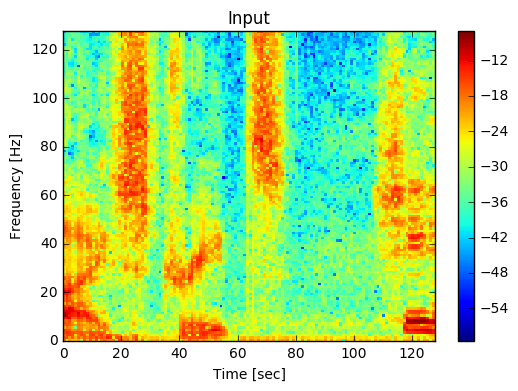

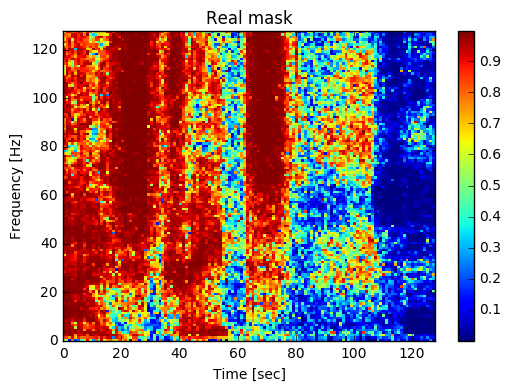

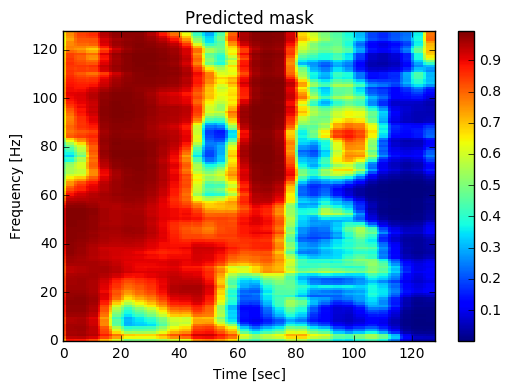

(<matplotlib.text.Text at 0x7f2618570be0>,
 <matplotlib.text.Text at 0x7f25f561c588>)

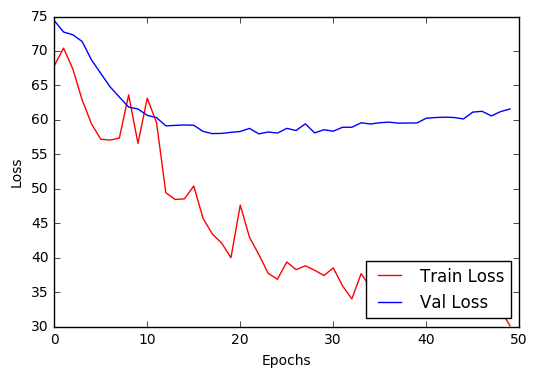

In [4]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import utils
from scipy.signal import spectrogram, istft
from test_mixer import TestMixer
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Reshape
from tensorflow.contrib.layers import flatten
import IPython

tf.reset_default_graph()


#Create the LibriSpeech mixer
mixer = TestMixer(nbSpeakers=1)
mixer.build_dataset_in_mem()

height, width, nchannels = mixer.nb_freq, mixer.spec_length, 1
padding = 'same'

filters_1 = 4
kernel_size_1 = (20,2)
kernel_size_2 = (2,20)
pool_size_1 = (2,4)
pool_size_2 = (4,4)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, height, width, 1], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding='valid')
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
    conv2 = Conv2D(2*filters_1, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    
    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding='valid')
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    reshape_size = x.get_shape()[1:]
    reshape_size = (int(reshape_size[0]), int(reshape_size[1]), int(reshape_size[2]))
     
    x = flatten(x)
    print('Flatten \t', x.get_shape())
    
    nb_units = int(x.get_shape()[1])
    
    dense1 = Dense(nb_units, activation='relu')
    x = dense1(x)
    print("Dense 1\t\t", x.get_shape())
    
    """dense2 = Dense(nb_units, activation='relu')
    x = dense2(x)
    print("Dense 2\t", x.get_shape())"""
    
    reshape = Reshape(reshape_size)
    x = reshape(x)
    print("Reshape \t", x.get_shape())
    
    upsampl1 = UpSampling2D(size=pool_size_2)
    x = upsampl1(x)
    print('upsampl1 \t', x.get_shape())
    
    deconv1 = Conv2DTranspose(filters_1, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = deconv1(x)
    print('deconv1 \t', x.get_shape())
    
    upsampl2 = UpSampling2D(size=pool_size_1)
    x = upsampl2(x)
    print('upsampl2 \t', x.get_shape())
    

with tf.variable_scope('output_layer'):
    deconv2 = Conv2DTranspose(1, kernel_size_1, strides=(1,1), padding=padding, activation='sigmoid')

    y = deconv2(x)
    print('deconv\t\t', y.get_shape())

print('Model consits of ', utils.num_params(), 'trainable parameters.')

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

"""## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)"""


with tf.variable_scope('loss'):
    # computing cross entropy per sample
    y_target1 = 10*tf.log(tf.multiply(x_pl, y_pl)+1e-10)/np.log(10)
    y_target2 = 10*tf.log(tf.multiply(x_pl, (1-y_pl))+1e-10)/np.log(10)
    y_pred1 = 10*tf.log(tf.multiply(x_pl, y)+1e-10)/np.log(10)
    y_pred2 = 10*tf.log(tf.multiply(x_pl, (1-y))+1e-10)/np.log(10)
    mean_square_error = tf.reduce_mean((y_target1 - y_pred1)**2) + tf.reduce_mean((y_target2 - y_pred2)**2)



with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(mean_square_error)

#Test the forward pass
batch_size = 10

x_batch, y_batch, _ = mixer.get_batch(batch_size)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!"         + " Output shape should be " + str(y_batch.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


# ## Training

#Training Loop

max_epochs = 50


valid_loss = []
train_loss = []
test_loss = []
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

def trainingLoop():
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:

            while mixer.epochs_completed < max_epochs:
                _train_loss = []

                ## Run train op
                x_batch, y_batch, _ = mixer.get_batch(batch_size)
                fetches_train = [train_op, mean_square_error]
                feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                _, _loss = sess.run(fetches_train, feed_dict_train)

                _train_loss.append(_loss)

                ## Compute validation loss
                if mixer.index_in_epoch < batch_size:
                    _valid_loss = []
                    train_loss.append(np.mean(_train_loss))

                    fetches_valid = [mean_square_error]

                    while mixer.epochs_completed_test <= mixer.epochs_completed:
                        x_valid, y_valid, _ = mixer.get_batch_test(batch_size)
                        feed_dict_valid = {x_pl: x_valid, y_pl: y_valid}
                        _loss = sess.run(fetches_valid, feed_dict_valid)

                        _valid_loss.append(_loss)

                    valid_loss.append(np.mean(_valid_loss))


                    print("Epoch {} : Train Loss {:6.3f}, Valid loss {:6.3f}".format(
                        mixer.epochs_completed, train_loss[-1], valid_loss[-1]))                 
        
        except KeyboardInterrupt:
            pass
        
        x_batch, y_batch, phase = mixer.get_batch(batch_size)
        phase = phase[0,:,:,0]
        y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
        
        sp_y1_targ = np.multiply(x_batch[0,:,:,0],y_batch[0,:,:,0])
        sp_y1_rec = np.multiply(x_batch[0,:,:,0],y_pred[0,:,:,0])
        sp_y2_targ = np.multiply((np.ones(x_batch[0,:,:,0].shape)-y_batch[0,:,:,0]), x_batch[0,:,:,0])
        sp_y2_rec = np.multiply((np.ones(x_batch[0,:,:,0].shape)-y_pred[0,:,:,0]), x_batch[0,:,:,0])

        sp_y1_rec_phase = []
        for i in range(len(sp_y1_rec)):
            rec_line = []
            for n in range(len(sp_y1_rec[0])) :
                rec_line.append( sp_y1_rec[i][n]*np.cos(phase[i][n]) + 1j*sp_y1_rec[i][n]*np.sin(phase[i][n]) )

            sp_y1_rec_phase.append(rec_line)
            
        sp_y2_rec_phase = []
        for i in range(len(sp_y2_rec)):
            rec_line = []
            for n in range(len(sp_y2_rec[0])) :
                rec_line.append( sp_y2_rec[i][n]*np.cos(phase[i][n]) + 1j*sp_y2_rec[i][n]*np.sin(phase[i][n]) )

            sp_y2_rec_phase.append(rec_line)
            
        sp_y1_targ_phase = []
        for i in range(len(sp_y1_targ)):
            rec_line = []
            for n in range(len(sp_y1_targ[0])) :
                rec_line.append( sp_y1_targ[i][n]*np.cos(phase[i][n]) + 1j*sp_y1_targ[i][n]*np.sin(phase[i][n]) )

            sp_y1_targ_phase.append(rec_line)
            
        sp_y2_targ_phase = []
        for i in range(len(sp_y2_targ)):
            rec_line = []
            for n in range(len(sp_y2_targ[0])) :
                rec_line.append(sp_y2_targ[i][n]*np.cos(phase[i][n]) + 1j*sp_y2_targ[i][n]*np.sin(phase[i][n]) )

            sp_y2_targ_phase.append(rec_line)
        
        framerate=16000
        t1, y1_targ = istft(sp_y1_targ_phase, fs=framerate)
        print('Speaker A target')
        IPython.display.display(IPython.display.Audio(y1_targ,rate=framerate))
        
        t1, y1_rec = istft(sp_y1_rec_phase, fs=framerate)
        print('Speaker A prediction')
        IPython.display.display(IPython.display.Audio(y1_rec,rate=framerate))
        
        t2, y2_targ = istft(sp_y2_targ_phase, fs=framerate)
        print('Speaker B target')
        IPython.display.display(IPython.display.Audio(y2_targ,rate=framerate))
        
        t2, y2_rec = istft(sp_y2_rec_phase, fs=framerate)
        print('Speaker B prediction')
        IPython.display.display(IPython.display.Audio(y2_rec,rate=framerate))



        
        plt.pcolormesh(10 * np.log10(x_batch[0,:,:,0]+1e-10))
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Input')
        plt.colorbar()
        plt.show()
        
                       
        plt.pcolormesh(y_batch[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Real mask')
        plt.colorbar()
        plt.show()
        
        plt.pcolormesh(y_pred[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Predicted mask')
        plt.colorbar()
        plt.show()
        
        save_path = saver.save(sess, "model.ckpt")
    
trainingLoop();


    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss,'r', epoch, valid_loss,'b')
plt.legend(['Train Loss','Val Loss'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Loss')

In [3]:
#Load the saved model and test it
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    x_batch, y_batch, phase = mixer.get_batch_test(batch_size)
    phase = phase[0,:,:,0]
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

    sp_y1_targ = np.multiply(x_batch[0,:,:,0],y_batch[0,:,:,0])
    sp_y1_rec = np.multiply(x_batch[0,:,:,0],y_pred[0,:,:,0])
    sp_y2_targ = np.multiply((np.ones(x_batch[0,:,:,0].shape)-y_batch[0,:,:,0]), x_batch[0,:,:,0])
    sp_y2_rec = np.multiply((np.ones(x_batch[0,:,:,0].shape)-y_pred[0,:,:,0]), x_batch[0,:,:,0])

    sp_y1_rec_phase = []
    for i in range(len(sp_y1_rec)):
        rec_line = []
        for n in range(len(sp_y1_rec[0])) :
            rec_line.append( sp_y1_rec[i][n]*np.cos(phase[i][n]) + 1j*sp_y1_rec[i][n]*np.sin(phase[i][n]) )

        sp_y1_rec_phase.append(rec_line)

    sp_y2_rec_phase = []
    for i in range(len(sp_y2_rec)):
        rec_line = []
        for n in range(len(sp_y2_rec[0])) :
            rec_line.append( sp_y2_rec[i][n]*np.cos(phase[i][n]) + 1j*sp_y2_rec[i][n]*np.sin(phase[i][n]) )

        sp_y2_rec_phase.append(rec_line)

    sp_y1_targ_phase = []
    for i in range(len(sp_y1_targ)):
        rec_line = []
        for n in range(len(sp_y1_targ[0])) :
            rec_line.append( sp_y1_targ[i][n]*np.cos(phase[i][n]) + 1j*sp_y1_targ[i][n]*np.sin(phase[i][n]) )

        sp_y1_targ_phase.append(rec_line)

    sp_y2_targ_phase = []
    for i in range(len(sp_y2_targ)):
        rec_line = []
        for n in range(len(sp_y2_targ[0])) :
            rec_line.append(sp_y2_targ[i][n]*np.cos(phase[i][n]) + 1j*sp_y2_targ[i][n]*np.sin(phase[i][n]) )

        sp_y2_targ_phase.append(rec_line)

    framerate=16000
    t1, y1_targ = istft(sp_y1_targ_phase, fs=framerate)
    print('Speaker A target')
    IPython.display.display(IPython.display.Audio(y1_targ,rate=framerate))

    t1, y1_rec = istft(sp_y1_rec_phase, fs=framerate)
    print('Speaker A prediction')
    IPython.display.display(IPython.display.Audio(y1_rec,rate=framerate))

    t2, y2_targ = istft(sp_y2_targ_phase, fs=framerate)
    print('Speaker B target')
    IPython.display.display(IPython.display.Audio(y2_targ,rate=framerate))

    t2, y2_rec = istft(sp_y2_rec_phase, fs=framerate)
    print('Speaker B prediction')
    IPython.display.display(IPython.display.Audio(y2_rec,rate=framerate))

INFO:tensorflow:Restoring parameters from model.ckpt
Model restored.
Speaker A target


Speaker A prediction


Speaker B target


Speaker B prediction
